In [1]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice
from sklearn import preprocessing

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

import torch
from torch import nn, optim

from finance.utilities import utils
from finance.data_science.utilities import (financial_utils, time_series_utils, 
                                            cluster_utils, random_forest_utils, nn_utils)

### Get stock data

In [2]:
date_start = '2005-01-01'
date_end = '2019-01-01'
normalization_window = 1000
smoothing_window = 10
forward_leap = 30
query = f"""
    with 
    tickers as (
    select distinct 
        ticker
        , sector
        , industry
    from nasdaq.listed_stocks
    where ticker in ('AA', 'MMM', 'GA', 'GE', 'AAPL', 'MSFT', 'DOW', 'AXP', 'IBM', 'JPM')
    limit 100
    ),
    stocks as (
        select 
            market_datetime
            , extract(year from market_datetime) as _year
            , extract(month from market_datetime) as month_of_year
            , extract(week from market_datetime) as week_of_year
            , symbol
            , sector
            , industry
            
            , open
            , avg(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as average_open_hundred_days
            , avg(open) over (partition by symbol order by market_datetime rows between 50 preceding and current row) as average_open_fifty_days
            , avg(open) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_open_ten_days
            , max(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as high_open_hundred_days
            , min(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as low_open_hundred_days
            , avg((open - close)/open) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_daily_finish_ten_days
            , avg((high - low)/high) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_daily_range_ten_days
            
            , volume
            , avg(volume) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as average_volume_hundred_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 50 preceding and current row) as average_volume_fifty_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_volume_ten_days
            
            , max(high) over (partition by symbol order by market_datetime rows between {normalization_window} preceding and current row) as high_open_n_days
            , min(low) over (partition by symbol order by market_datetime rows between {normalization_window} preceding and current row) as low_open_n_days
        from td.equities as equities
        inner join tickers
            on tickers.ticker = equities.symbol
        where market_datetime > '{date_start}' and market_datetime < '{date_end}'
        ),
    summary as (
        select *
            , (average_open_hundred_days - average_open_fifty_days) / average_open_hundred_days as hundred_fifty_average_open_diff
            , (average_open_fifty_days - average_open_ten_days) / average_open_fifty_days as fifty_ten_average_open_diff
            , (high_open_hundred_days - low_open_hundred_days) / high_open_hundred_days as hundred_high_low_open_diff
            , (average_volume_hundred_days - average_volume_fifty_days) / average_volume_hundred_days as hundred_fifty_average_volume_diff
            , (average_volume_fifty_days - average_volume_ten_days) / average_volume_fifty_days as fifty_ten_average_volume_diff
            , high_open_n_days - low_open_n_days as normalization_range
            , (open - low_open_n_days) / (high_open_n_days - low_open_n_days) as normalized_open
        from stocks
        where market_datetime > '{date_start}'::date + interval '100' day
        and market_datetime < '{date_end}'::date - interval '10' day
        ),
    aggregates as (
        select *
            , avg(hundred_fifty_average_open_diff) over (partition by market_datetime, sector) as sector_hundred_fifty_average_open_diff
            , avg(fifty_ten_average_open_diff) over (partition by market_datetime, sector) as sector_fifty_ten_average_open_diff
            , avg(hundred_high_low_open_diff) over (partition by market_datetime, sector) as sector_hundred_high_low_open_diff
            , avg(fifty_ten_average_volume_diff) over (partition by market_datetime, sector) as sector_fifty_ten_average_volume_diff
            , avg(hundred_fifty_average_open_diff) over (partition by market_datetime, industry) as industry_hundred_fifty_average_open_diff
            , avg(fifty_ten_average_open_diff) over (partition by market_datetime, industry) as industry_fifty_ten_average_open_diff
            , avg(hundred_high_low_open_diff) over (partition by market_datetime, industry) as industry_hundred_high_low_open_diff
            , avg(fifty_ten_average_volume_diff) over (partition by market_datetime, industry) as industry_fifty_ten_average_volume_diff
            , avg(hundred_fifty_average_open_diff) over (partition by market_datetime) as market_hundred_fifty_average_open_diff
            , avg(fifty_ten_average_open_diff) over (partition by market_datetime) as market_fifty_ten_average_open_diff
            , avg(hundred_high_low_open_diff) over (partition by market_datetime) as market_hundred_high_low_open_diff
            , avg(fifty_ten_average_volume_diff) over (partition by market_datetime) as market_fifty_ten_average_volume_diff
            , avg(normalized_open) over (partition by symbol order by market_datetime rows between {smoothing_window} preceding and current row) as smoothed_normalized_open
        from summary
        ),
    final as (
        select *
            , lead(smoothed_normalized_open, {forward_leap}) over (partition by symbol order by market_datetime) as target
        from aggregates
        order by market_datetime, symbol)
    select *
    from final
    where target is not null
    """

df = utils.query_db(query=query)
df.head()

,market_datetime,_year,month_of_year,week_of_year,symbol,sector,industry,open,average_open_hundred_days,average_open_fifty_days,...,industry_hundred_fifty_average_open_diff,industry_fifty_ten_average_open_diff,industry_hundred_high_low_open_diff,industry_fifty_ten_average_volume_diff,market_hundred_fifty_average_open_diff,market_fifty_ten_average_open_diff,market_hundred_high_low_open_diff,market_fifty_ten_average_volume_diff,smoothed_normalized_open,target
0,2005-04-11 05:00:00,2005.0,4.0,15.0,AA,Basic Industries,Aluminum,94.380003,91.272353,91.857059,...,-0.006406,0.003531,0.127686,-0.133083,0.001145,0.019274,0.10225,-0.002756,0.806075,0.217641
1,2005-04-11 05:00:00,2005.0,4.0,15.0,AXP,Finance,Finance: Consumer Services,44.125230,45.872484,45.850085,...,0.000488,0.040866,0.110247,0.178383,0.001145,0.019274,0.10225,-0.002756,0.182045,0.370892
2,2005-04-11 05:00:00,2005.0,4.0,15.0,GE,Energy,Consumer Electronics/Appliances,35.760000,35.819853,35.820980,...,-0.000031,0.002718,0.044402,0.029851,0.001145,0.019274,0.10225,-0.002756,0.417526,0.647067
3,2005-04-11 05:00:00,2005.0,4.0,15.0,IBM,Technology,Computer Manufacturing,87.350000,92.634118,91.876863,...,0.008175,0.022694,0.117409,-0.173847,0.001145,0.019274,0.10225,-0.002756,0.096849,0.104921
4,2005-04-11 05:00:00,2005.0,4.0,15.0,JPM,Finance,Major Banks,34.670000,36.773971,36.363529,...,0.011161,0.048772,0.147163,-0.029369,0.001145,0.019274,0.10225,-0.002756,0.208202,0.319042


### Clean data

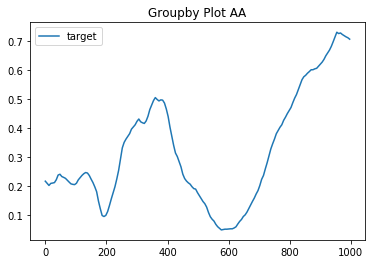

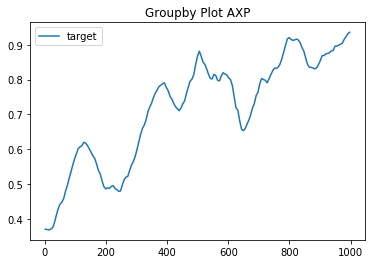

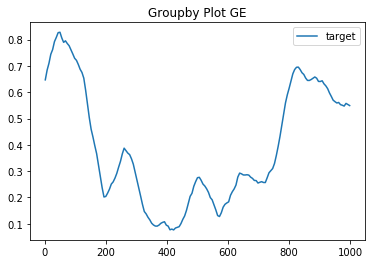

In [3]:
cluster_utils.plot_prediction_groupby(df=df.head(1000), groupby='symbol', n_plots=2, lines=['target'])

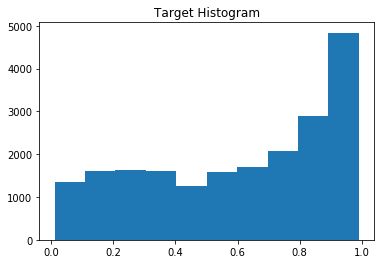

In [4]:
plt.hist(df.loc[df['target'].notnull(), 'target'])
plt.title('Target Histogram')
plt.show()

In [5]:
df['market_datetime_month'] = df['market_datetime'].dt.month
df['market_datetime_day_of_week'] = df['market_datetime'].dt.dayofweek

df['market_datetime_int'] = df['market_datetime'].astype(int)

In [6]:
cols_to_ignore = ['symbol', 'sector', 'industry', 'market_datetime', 'market_datetime_month', 
                  'market_datetime_day_of_week', 'target']

time_cols = ['_year', 'month_of_year', 'week_of_year']

df['_year'] = (df['_year'] - df['_year'].min())/(2030-df['_year'].min())
df['month_of_year'] = df['month_of_year']/12
df['week_of_year'] = df['week_of_year']/52

for col in df.drop(cols_to_ignore + time_cols, axis=1).columns:
    df = cluster_utils.normalize(df=df, column=col, subset='symbol')

df = cluster_utils.encode_one_hot(df, ['sector', 'industry', 
                                       'market_datetime_month', 'market_datetime_day_of_week'])

df = df.fillna(1)

In [7]:
for time_shift in range(30, 60):
    df['target' + '_' + str(time_shift)] = df['target'].shift(time_shift)

df = df.dropna()

In [8]:
temp = df.copy()

y = temp['target']

x = temp[~y.isna()].reset_index(drop=True)
y = y[~y.isna()].reset_index(drop=True)

split = .5
cutoff = int(len(x) * .75)

train_x = x.iloc[:cutoff]
test_x = x.iloc[cutoff:]

train_y = y.iloc[:cutoff]
test_y = y.iloc[cutoff:]

In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(train_x.drop(cols_to_ignore, axis=1).tail(2).T)

                                             15351     15352
_year                                     0.400000  0.400000
month_of_year                             0.500000  0.500000
week_of_year                              0.500000  0.500000
open                                      1.000000  1.000000
average_open_hundred_days                 1.000000  0.000000
average_open_fifty_days                   1.000000  0.000000
average_open_ten_days                     1.000000  0.146417
high_open_hundred_days                    1.000000  1.000000
low_open_hundred_days                     1.000000  0.000000
average_daily_finish_ten_days             0.303481  0.000000
average_daily_range_ten_days              0.000000  0.562485
volume                                    0.263662  0.000000
average_volume_hundred_days               0.081985  0.000000
average_volume_fifty_days                 1.000000  0.852596
average_volume_ten_days                   0.630354  0.254883
high_open_n_days        

### Create nn

In [10]:
n_rows = 15000
m_rows = int(n_rows/10)
model = nn_utils.TorchLSTM(train_x=train_x.head(n_rows).drop(cols_to_ignore, axis=1), 
                           train_y=train_y.head(n_rows),
                           test_x=test_x.head(m_rows).drop(cols_to_ignore, axis=1), 
                           test_y=test_y.head(m_rows),
                           n_layers=2,
                           n_epochs=500,
                           # batch_size=100,
                           hidden_shape=500,
                           dropout=.95,
                           learning_rate=.0001,
                           device='cuda:0')

Epoch  0 Error:  8692.94140625
Epoch  50 Error:  3812.7119140625
Epoch  100 Error:  3243.02685546875
Epoch  150 Error:  2320.386962890625
Epoch  200 Error:  1907.43505859375
Epoch  250 Error:  1706.419189453125
Epoch  300 Error:  1565.784912109375
Epoch  350 Error:  1429.4515380859375
Epoch  400 Error:  1328.7998046875
Epoch  450 Error:  1227.81201171875


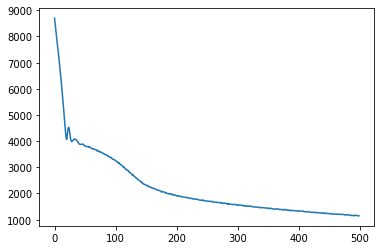

In [11]:
model.execute()

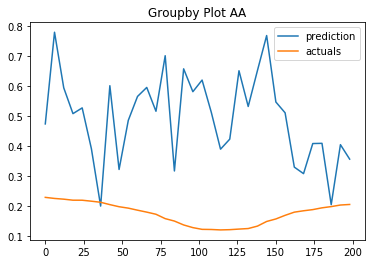

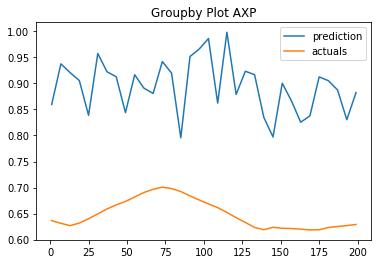

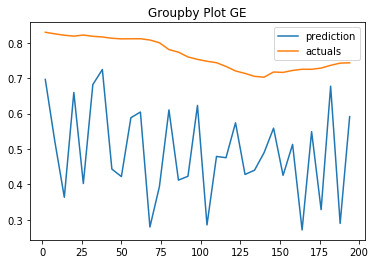

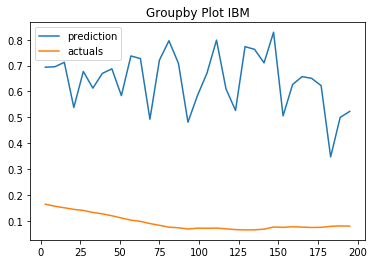

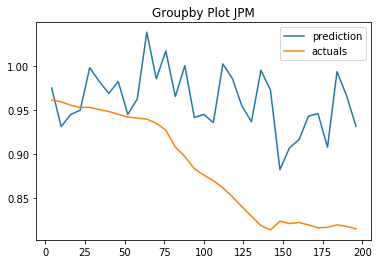

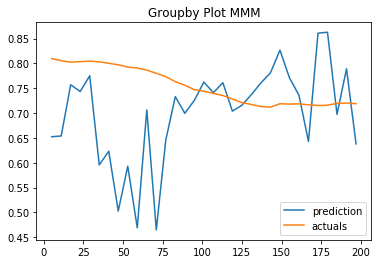

In [12]:
temp = model.test_df
temp['symbol'] = test_x['symbol'].head(m_rows).values
cluster_utils.plot_prediction_groupby(df=temp.head(200), groupby='symbol')

In [13]:
model.reset_network()